In [5]:
import os, glob, json
for folder in glob.glob("qwen*"):
    for file in glob.glob(f"{folder}/stream-of-search*.json"):
        # with open(file, "r") as f:
        #     data = json.load(f)
        #     print(data)
        # break
        print(file)

qwen-2.5-1.5B-instruct-sft-lora-countdown-o3-1k_MelinaLaimon/stream-of-search_train_128_20250330-051804.json
qwen-2.5-1.5B-instruct-sft-lora-countdown-o3-1k_MelinaLaimon/stream-of-search_test_128_20250330-052400.json
qwen-2.5-1.5B-instruct-sft-lora-countdown-o3-1k_MelinaLaimon/stream-of-search_train_128_20250330-055052.json
qwen-2.5-1.5B-instruct-sft-lora-countdown-o3-1k_MelinaLaimon/stream-of-search_test_128_20250330-055645.json
qwen-2.5-1.5B-instruct-sft-lora-countdown-o3-1k_MelinaLaimon/stream-of-search_train_64_20250330-112336.json
qwen-2.5-1.5B-instruct-sft-lora-countdown-o3-1k_MelinaLaimon/stream-of-search_test_64_20250330-112513.json
qwen-2.5-1.5B-instruct-sft-lora-countdown-o3-1k_MelinaLaimon/stream-of-search_train_128_20250330-163437.json
qwen-2.5-1.5B-instruct-sft-lora-countdown-o3-1k_MelinaLaimon/stream-of-search_test_128_20250330-164311.json
qwen-2.5-1.5B-instruct-sft-lora-countdown-search-react-5k_MelinaLaimon/stream-of-search_train_64_20250330-132320.json
qwen-2.5-1.5B-in

20250330051136-distributed-eval-qwen-2.5-1.5B-instruct-sft-lora-countdown-o3-1k
20250330051136-distributed-eval-qwen-2.5-1.5B-instruct-sft-lora-countdown-o3-1k
20250330054418-distributed-eval-qwen-2.5-1.5B-instruct-sft-lora-countdown-o3-1k
20250330054418-distributed-eval-qwen-2.5-1.5B-instruct-sft-lora-countdown-o3-1k
20250330112138-distributed-eval-qwen-2.5-1.5B-instruct-sft-lora-countdown-o3-1k
20250330112138-distributed-eval-qwen-2.5-1.5B-instruct-sft-lora-countdown-o3-1k
20250330162156-distributed-eval-qwen-2.5-1.5B-instruct-sft-lora-countdown-o3-1k
20250330162156-distributed-eval-qwen-2.5-1.5B-instruct-sft-lora-countdown-o3-1k
20250330112138-distributed-eval-qwen-2.5-1.5B-instruct-sft-lora-countdown-search-react-5k
20250330112138-distributed-eval-qwen-2.5-1.5B-instruct-sft-lora-countdown-search-react-5k
20250330051145-distributed-eval-qwen-2.5-0.5B-instruct-sft-lora-countdown-search-1k
20250330112236-distributed-eval-qwen-2.5-0.5B-instruct-sft-lora-countdown-search-1k
202503301122

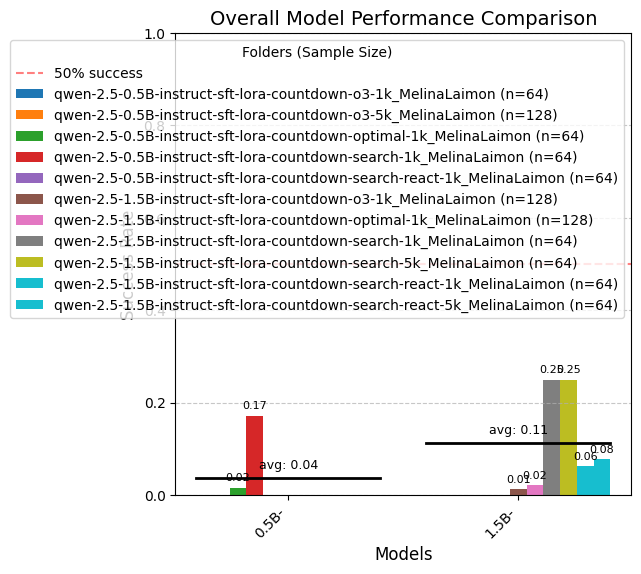

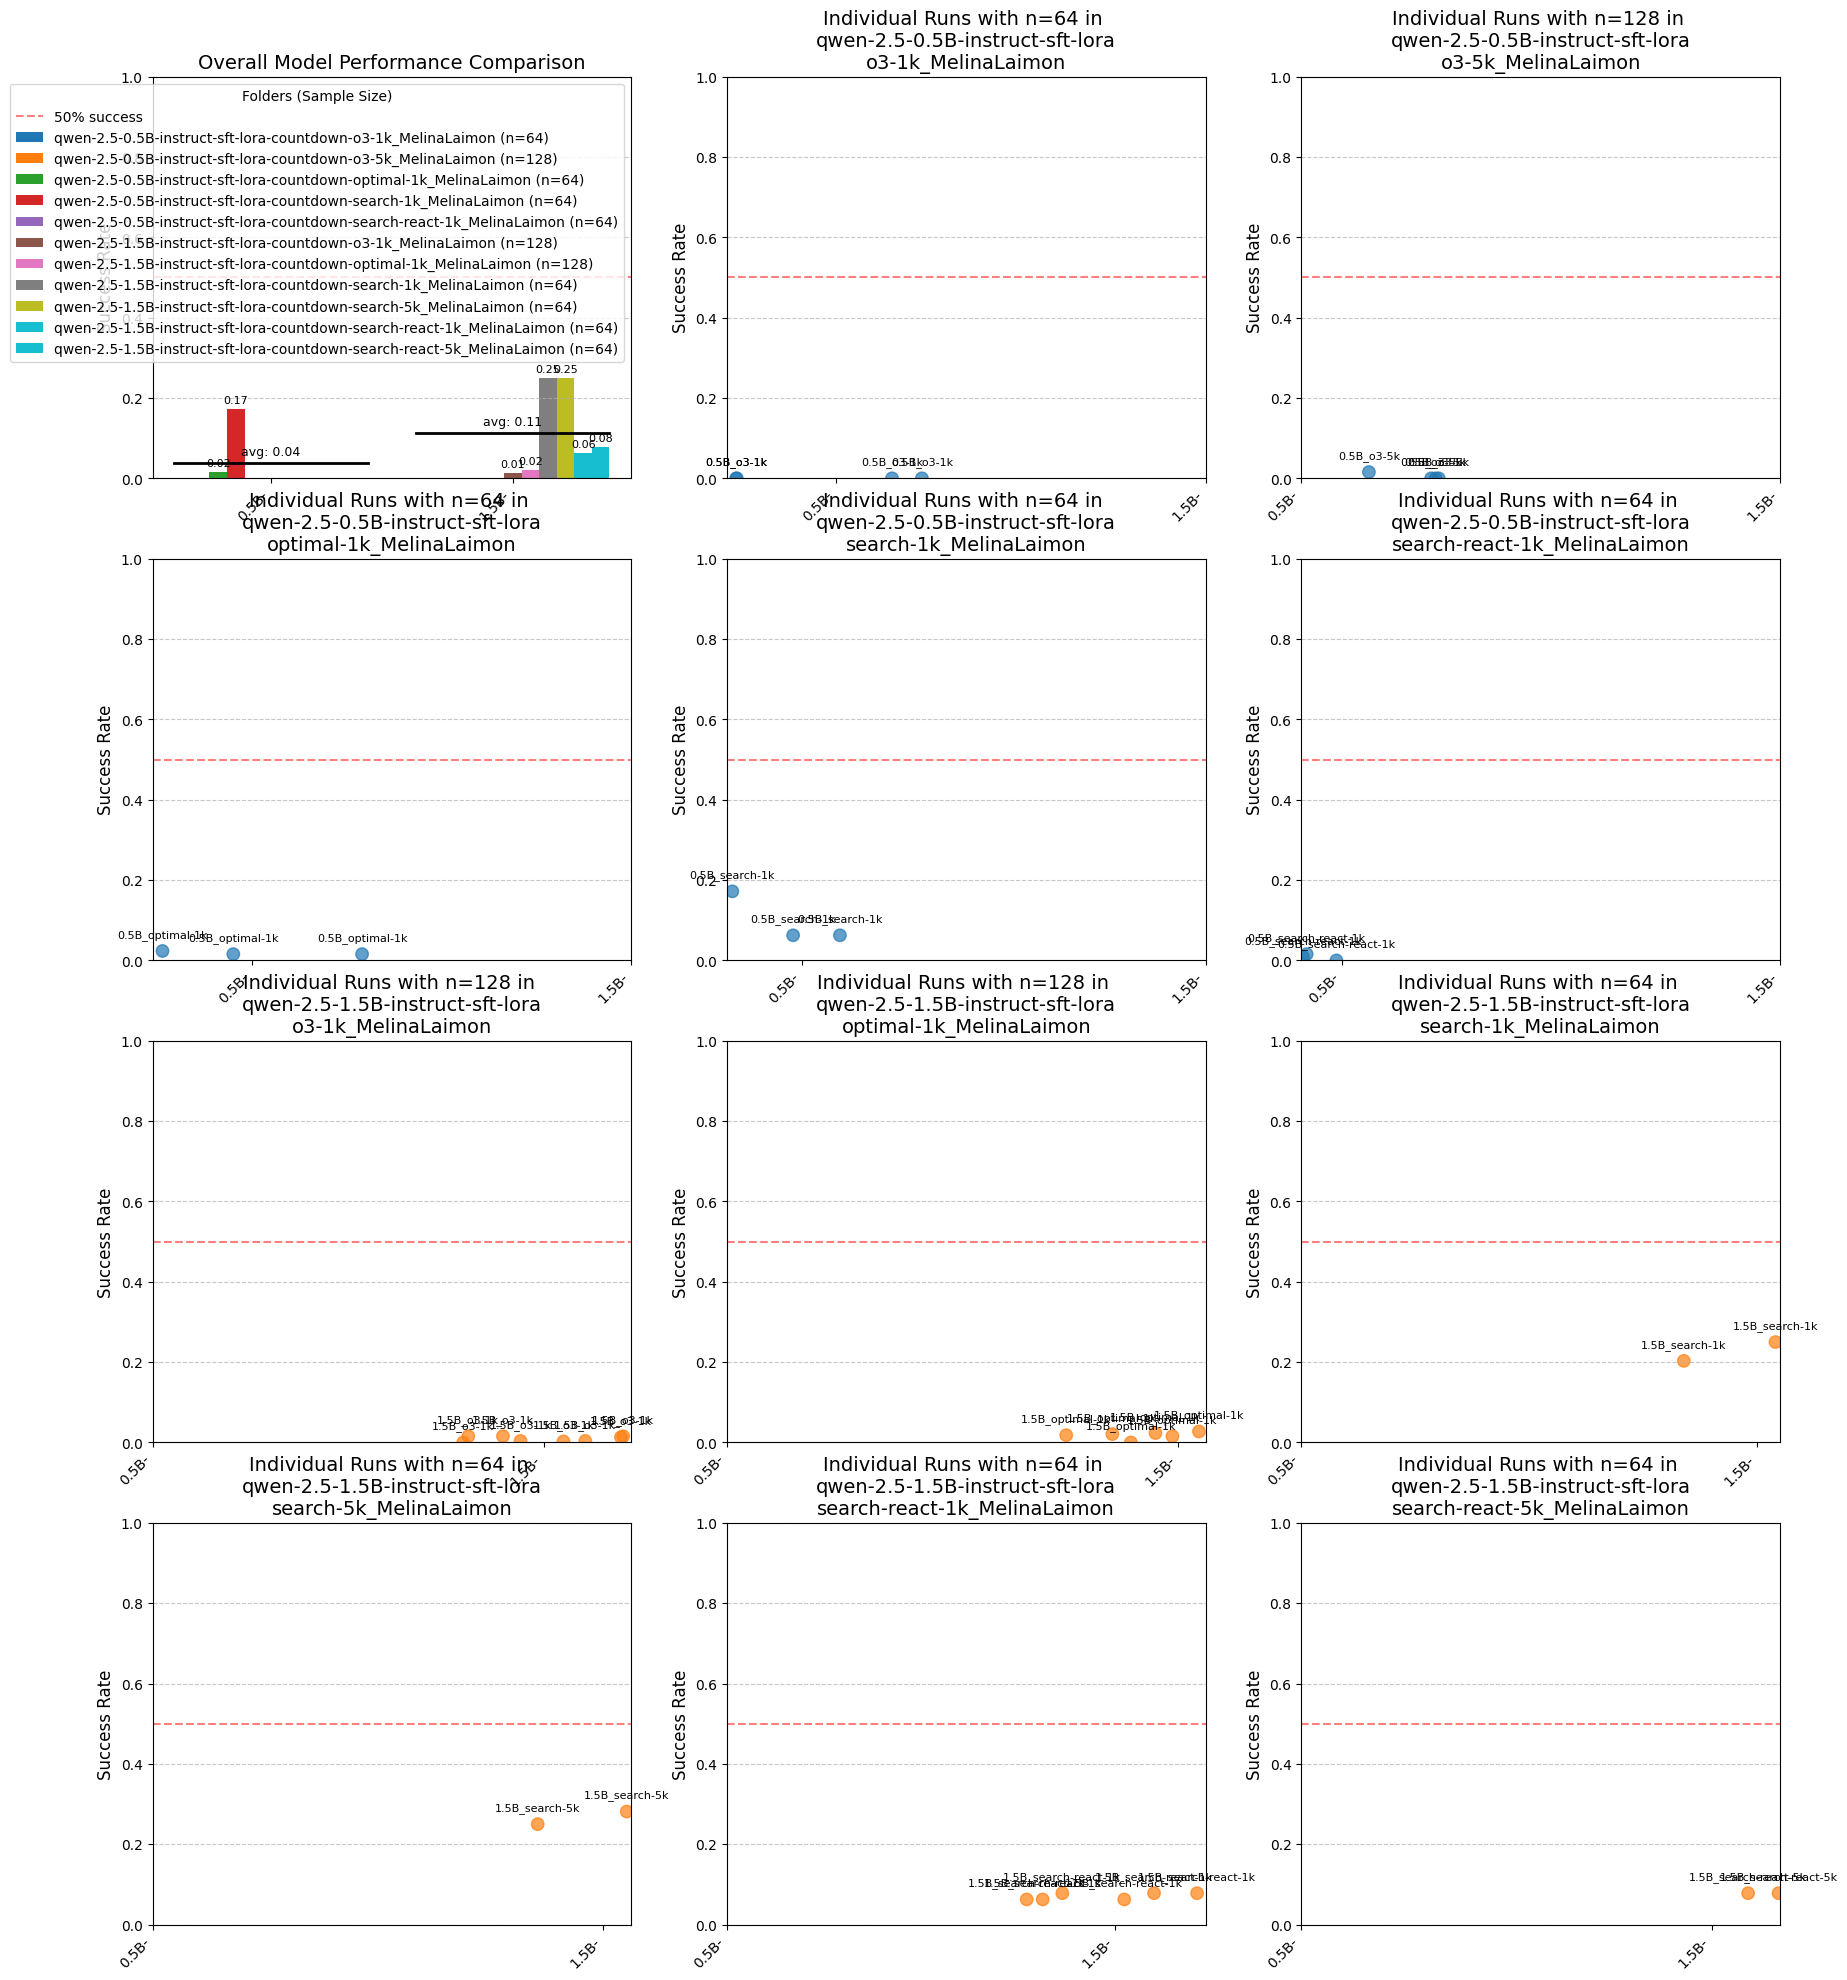

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import json
import glob
import os
import re


def extract_parts(string):
    pattern = re.compile(r'(\d+\.\d+B).*countdown-(.+?)$')
    match = pattern.search(string)
    return [match.group(1), match.group(2)]

# Dictionary to store data by model and folder
data_by_model = {}
# Store individual run data
run_details = {}
# Dictionary to store sample sizes by folder
folder_sample_sizes = {}

for folder in glob.glob("qwen*"):
    folder_name = os.path.basename(folder)
    
    for file in glob.glob(f"{folder}/stream-of-search*.json"):
        with open(file, "r") as f:
            data = json.load(f)
        
        hyperparams = data[0]['hyperparams']
        mean = data[1]['mean']
        model_name = hyperparams['adapter'].split("instruct")[0].split("2.5-")[-1]
        sample_size = hyperparams['num']
        experiment_name = hyperparams.get('experiment_name', os.path.basename(file))
        print(experiment_name)
        experiment_name = "_".join(extract_parts(experiment_name))
        # Store folder sample size
        folder_sample_sizes[folder_name] = sample_size
        
        run_id = f"{model_name}_{folder_name}_{os.path.basename(file)}"
        run_details[run_id] = {
            "success_rate": mean,
            "model": model_name,
            "folder": folder_name,
            "file": os.path.basename(file),
            "sample_size": sample_size,
            "experiment_name": experiment_name.split(".json")[0]
        }
        
        if model_name not in data_by_model:
            data_by_model[model_name] = {}
        
        data_by_model[model_name][folder_name] = mean

# Get unique model names and folder names
models = sorted(data_by_model.keys())
folder_names = sorted(set(folder for model_data in data_by_model.values() for folder in model_data.keys()))

# Create a figure with 3 subplots (1 row, 3 columns)
fig = plt.figure(figsize=(20, 6))

# 1. Overall Comparison Plot (first subplot)
ax_main = plt.subplot(1, 3, 1)

# Set up the bar chart
x = np.arange(len(models))
width = 0.8 / len(folder_names)  # Width of each bar
colors = plt.cm.tab10(np.linspace(0, 1, len(folder_names)))

# Plot bars for each folder
for i, folder in enumerate(folder_names):
    values = [data_by_model[model].get(folder, 0) for model in models]
    sample_size = folder_sample_sizes.get(folder, "Unknown")
    bars = ax_main.bar(x + i*width - (len(folder_names)-1)*width/2, values, 
                       width=width, label=f"{folder} (n={sample_size})", color=colors[i])
    
    # Add value labels
    for bar, value in zip(bars, values):
        height = bar.get_height()
        if height > 0:  # Only label non-zero bars
            ax_main.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                        f"{value:.2f}", ha='center', va='bottom', 
                        fontsize=8)

# Calculate average success rate per model
model_avg = {model: np.mean([value for value in data_by_model[model].values()]) 
             for model in models}

# Plot average line
avg_values = [model_avg[model] for model in models]
for i, (x_pos, y_pos) in enumerate(zip(x, avg_values)):
    ax_main.plot([x_pos-0.4, x_pos+0.4], [y_pos, y_pos], color='black', linestyle='-', linewidth=2)
    ax_main.text(x_pos, y_pos + 0.02, f"avg: {y_pos:.2f}", ha='center', fontsize=9)

# Configure the plot
ax_main.set_xlabel('Models', fontsize=12)
ax_main.set_ylabel('Success Rate', fontsize=12)
ax_main.set_title('Overall Model Performance Comparison', fontsize=14)
ax_main.set_xticks(x)
ax_main.set_xticklabels(models, rotation=45, ha='right', fontsize=10)
ax_main.set_ylim(0, 1)
ax_main.grid(axis='y', linestyle='--', alpha=0.7)
ax_main.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label="50% success")
ax_main.legend(title='Folders (Sample Size)', loc='upper right')

# Group run details by folder
runs_by_folder = {}
for run_id, details in run_details.items():
    folder = details['folder']
    if folder not in runs_by_folder:
        runs_by_folder[folder] = []
    runs_by_folder[folder].append(details)

# Map model names to numeric indices for scatter plot x-positions
model_indices = {model: i for i, model in enumerate(models)}

# # 2. Scatter plot for the first folder
# if len(folder_names) > 0:
#     first_folder = folder_names[0]
#     ax_folder1 = plt.subplot(1, 3, 2)
    
#     if first_folder in runs_by_folder:
#         folder_runs = runs_by_folder[first_folder]
        
#         # Prepare data for scatter plot
#         x_positions = []
#         y_values = []
#         colors_list = []
#         experiment_names = []
        
#         for run in folder_runs:
#             model = run['model']
#             if model in model_indices:
#                 x_pos = model_indices[model]
#                 x_positions.append(x_pos)
#                 y_values.append(run['success_rate'])
#                 colors_list.append(plt.cm.tab10(model_indices[model] % 10))
#                 experiment_names.append(run['experiment_name'])
        
#         # Add some jitter to x positions
#         x_jittered = [x + np.random.uniform(-0.3, 0.3) for x in x_positions]
        
#         # Create scatter plot
#         ax_folder1.scatter(x_jittered, y_values, c=colors_list, alpha=0.7, s=80)
        
#         # Annotate with experiment names
#         for i in range(len(x_jittered)):
#             ax_folder1.annotate(experiment_names[i], (x_jittered[i], y_values[i]), 
#                               textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)
        
#         # Configure the plot
#         ax_folder1.set_xlabel('Models', fontsize=12)
#         ax_folder1.set_ylabel('Success Rate', fontsize=12)
#         sample_size = folder_sample_sizes.get(first_folder, "Unknown")
#         ax_folder1.set_title(f'Individual Runs in {first_folder} (n={sample_size})', fontsize=14)
#         ax_folder1.set_xticks(range(len(models)))
#         ax_folder1.set_xticklabels(models, rotation=45, ha='right', fontsize=10)
#         ax_folder1.set_ylim(0, 0.2)
#         ax_folder1.grid(axis='y', linestyle='--', alpha=0.7)
#         ax_folder1.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
#     else:
#         ax_folder1.text(0.5, 0.5, f"No run details available for {first_folder}", 
#                      ha='center', va='center')
#         ax_folder1.set_title(f'{first_folder}', fontsize=14)
#         ax_folder1.axis('off')

# # 3. Scatter plot for the second folder
# if len(folder_names) > 1:
#     second_folder = folder_names[1]
#     ax_folder2 = plt.subplot(1, 3, 3)
    
#     if second_folder in runs_by_folder:
#         folder_runs = runs_by_folder[second_folder]
        
#         # Prepare data for scatter plot
#         x_positions = []
#         y_values = []
#         colors_list = []
#         experiment_names = []
        
#         for run in folder_runs:
#             model = run['model']
#             if model in model_indices:
#                 x_pos = model_indices[model]
#                 x_positions.append(x_pos)
#                 y_values.append(run['success_rate'])
#                 colors_list.append(plt.cm.tab10(model_indices[model] % 10))
#                 experiment_names.append(run['experiment_name'])
        
#         # Add some jitter to x positions
#         x_jittered = [x + np.random.uniform(-0.3, 0.3) for x in x_positions]
        
#         # Create scatter plot
#         ax_folder2.scatter(x_jittered, y_values, c=colors_list, alpha=0.7, s=80)
        
#         # Annotate with experiment names
#         for i in range(len(x_jittered)):
#             ax_folder2.annotate(experiment_names[i], (x_jittered[i], y_values[i]), 
#                              textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)
        
#         # Configure the plot
#         ax_folder2.set_xlabel('Models', fontsize=12)
#         ax_folder2.set_ylabel('Success Rate', fontsize=12)
#         sample_size = folder_sample_sizes.get(second_folder, "Unknown")
#         ax_folder2.set_title(f'Individual Runs in {second_folder} (n={sample_size})', fontsize=14)
#         ax_folder2.set_xticks(range(len(models)))
#         ax_folder2.set_xticklabels(models, rotation=45, ha='right', fontsize=10)
#         ax_folder2.set_ylim(0, 0.2)
#         ax_folder2.grid(axis='y', linestyle='--', alpha=0.7)
#         ax_folder2.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
#     else:
#         ax_folder2.text(0.5, 0.5, f"No run details available for {second_folder}", 
#                      ha='center', va='center')
#         ax_folder2.set_title(f'{second_folder}', fontsize=14)
#         ax_folder2.axis('off')

# plt.tight_layout()
# plt.savefig("model_comparison.png")
# plt.show()


# Calculate number of plots: 1 overall + 1 per folder
num_plots = 1 + len(folder_names)

# Determine layout: use 3 columns maximum
num_cols = min(3, num_plots)
num_rows = (num_plots + num_cols - 1) // num_cols  # Ceiling division

# Create figure with appropriate size
fig = plt.figure(figsize=(7*num_cols, 6*num_rows))

# 1. Overall Comparison Plot (first subplot)
ax_main = plt.subplot(num_rows, num_cols, 1)

# Set up the bar chart
x = np.arange(len(models))
width = 0.8 / len(folder_names)  # Width of each bar
colors = plt.cm.tab10(np.linspace(0, 1, len(folder_names)))

# Plot bars for each folder
for i, folder in enumerate(folder_names):
    values = [data_by_model[model].get(folder, 0) for model in models]
    sample_size = folder_sample_sizes.get(folder, "Unknown")
    bars = ax_main.bar(x + i*width - (len(folder_names)-1)*width/2, values, 
                       width=width, label=f"{folder} (n={sample_size})", color=colors[i])
    
    # Add value labels
    for bar, value in zip(bars, values):
        height = bar.get_height()
        if height > 0:  # Only label non-zero bars
            ax_main.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                        f"{value:.2f}", ha='center', va='bottom', 
                        fontsize=8)

# Calculate average success rate per model
model_avg = {model: np.mean([value for value in data_by_model[model].values()]) 
             for model in models}

# Plot average line
avg_values = [model_avg[model] for model in models]
for i, (x_pos, y_pos) in enumerate(zip(x, avg_values)):
    ax_main.plot([x_pos-0.4, x_pos+0.4], [y_pos, y_pos], color='black', linestyle='-', linewidth=2)
    ax_main.text(x_pos, y_pos + 0.02, f"avg: {y_pos:.2f}", ha='center', fontsize=9)

# Configure the plot
# ax_main.set_xlabel('Models', fontsize=12)
ax_main.set_ylabel('Success Rate', fontsize=12)
ax_main.set_title('Overall Model Performance Comparison', fontsize=14)
ax_main.set_xticks(x)
ax_main.set_xticklabels(models, rotation=45, ha='right', fontsize=10)
ax_main.set_ylim(0, 1)
ax_main.grid(axis='y', linestyle='--', alpha=0.7)
ax_main.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label="50% success")
ax_main.legend(title='Folders (Sample Size)', loc='upper right')

# Map model names to numeric indices for scatter plot x-positions
model_indices = {model: i for i, model in enumerate(models)}

# Create scatter plot for each folder
for i, folder in enumerate(folder_names):
    # Create subplot (i+2 because position 1 is for overall comparison)
    ax_folder = plt.subplot(num_rows, num_cols, i+2)
    
    if folder in runs_by_folder:
        folder_runs = runs_by_folder[folder]
        
        # Prepare data for scatter plot
        x_positions = []
        y_values = []
        colors_list = []
        experiment_names = []
        
        for run in folder_runs:
            model = run['model']
            if model in model_indices:
                x_pos = model_indices[model]
                x_positions.append(x_pos)
                y_values.append(run['success_rate'])
                colors_list.append(plt.cm.tab10(model_indices[model] % 10))
                experiment_names.append(run['experiment_name'])
        
        # Add some jitter to x positions
        x_jittered = [x + np.random.uniform(-0.3, 0.3) for x in x_positions]
        
        # Create scatter plot
        ax_folder.scatter(x_jittered, y_values, c=colors_list, alpha=0.7, s=80)
        
        # Annotate with experiment names
        for j in range(len(x_jittered)):
            ax_folder.annotate(experiment_names[j], (x_jittered[j], y_values[j]), 
                              textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)
        
        # Configure the plot
        # ax_folder.set_xlabel('Models', fontsize=12)
        ax_folder.set_ylabel('Success Rate', fontsize=12)
        sample_size = folder_sample_sizes.get(folder, "Unknown")
        ax_folder.set_title(f"Individual Runs with n={sample_size} in \n" + "\n".join(folder.split('-countdown-')), fontsize=14)
        ax_folder.set_xticks(range(len(models)))
        ax_folder.set_xticklabels(models, rotation=45, ha='right', fontsize=10)
        ax_folder.set_ylim(0, 1.0)
        ax_folder.grid(axis='y', linestyle='--', alpha=0.7)
        ax_folder.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
        
    else:
        ax_folder.text(0.5, 0.5, f"No run details available for {folder}", 
                     ha='center', va='center')
        ax_folder.set_title(f'{folder}', fontsize=14)
        ax_folder.axis('off')

# plt.tight_layout()
plt.savefig("model_comparison.png", dpi=300) # , bbox_inches='tight')
# plt.show()


In [9]:
"\n".join(folder.split('-countdown-'))

'qwen-2.5-1.5B-instruct-sft-lora\nsearch-react-5k_MelinaLaimon'